<p>
<center>Decorators! You Should Use Them More</center>
===============================================
<center>![Decorators](http://www.moma.org/explore/inside_out/inside_out/wp-content/uploads/2010/03/At-symbol-4.sm_1.jpg)</center>

What is the Thing?
==================

    - Not a special as they think they are.
    - Fancy way of making a function sandwich.

In [1]:
# Function composition with ints
def f(x):
    return x
def g(x):
    return x + 1

g(f(2))

3

When I talk about function composition, this is what I'm talking about- taking the output of one function, and directly feeding it into another function.

You've likely seen this more in mathematics, or in functional programming languages.

In [2]:
def fred():
    print("Hi, I'm Fred.")

In [3]:
gred = fred

It should be noted that in python, functions can be passed around or set to a variable, just like any other type. In this way, they can also be passed into other functions as parameters.

In [4]:
gred

<function __main__.fred>

In [5]:
def gred(x):
    """Function to call another function.
    
    Parameters
    ----------
    x : callable
    """
    return x()

So in this example, I'm going to repurpose gred. It's not going to be a reference to fred anymore. Instead, it's going to be a function that takes in a callable function, x, and calls it.

In [6]:
gred(fred)

Hi, I'm Fred.


Why Do We Want to Do the Thing?
==================

    - Additions to Unchangable Code
    - Concision of Code
    - Pre/Post Processing

Unchangable Code:
    - If you have a block of code that you don't want changed (or, that can't be changed, because it's imported from somewhere else, decorators allow you to examine inputs and outputs, perform actions based on those, and execute the original function, unmarred. This can be as simple as printing the return to another output, or more complex, like examing incoming arguments for particular characteristics, across MANY functions.

Concision of Code:
    - If you have something you want to do often, but to different functions, without having to re-write the same function block or function call in every function you want that action in.

Pre/Post Processing:
    - If you know that the return of a function is going to be of a particular type, you can tack on a decorator to post process that data in a different fashion. Alternately, use a decorator to pre-process the arguments, before they're even fed in.

In [7]:
def greeting(unchanging_introduce_func):
    def introduce(*args, **kwargs):
        print("Hello, I'm George.")
        unchanging_introduce_func(*args, **kwargs)
        print(
            "Nice to meet you, %s, I'm George." % 
            unchanging_introduce_func.__name__
        )
    return introduce

In [8]:
@greeting
def fred():
    print("Hi, I'm Fred.")

In [11]:
fred()

Hello, I'm George.
Hi, I'm Fred.
Nice to meet you, fred, I'm George.


Ho-Hum. What Else Can You Do?
==============================

    - Let's take a look at another function. 
    - This one does something "longer".
    - (Mostly because we force it to.)
    - (You'll see.)

In [12]:
import time
def play_match():
    points = 0
    while points < 150:   
        time.sleep(0.001)
        points += 1
    else:
        print('Snitch was caught!')

In [13]:
play_match()

Snitch was caught!


Excuse Me, I Have Some Concerns
=====================================================

    - This is nice, but we have no idea how long that took.
    - What if this was a world-record-setting match? We'd never know.
    - Need to find a way to keep track of how long this is taking.

In [14]:
def timer(unchanging_func):
    def inner(*args, **kwargs):
        t = time.time()
        unchanging_func(*args, **kwargs)
        print(
            '%s took %0.2f seconds.' %
            (unchanging_func.__name__, time.time() - t)
        )
    return inner

In [16]:
@timer
def play_match():
    points = 0
    while points < 150:
        time.sleep(0.001)
        points += 1
    else:
        print('Snitch was caught!')

In [17]:
play_match()

Snitch was caught!
play_match took 0.20 seconds.


In [18]:
# Check equivalency of using @ syntax.
def play_match():
    points = 0
    while points < 150:
        time.sleep(0.001)
        points += 1
    else:
        print('Snitch was caught!')

play_match_func = timer(play_match)
# Need to call at the end, because timer returns a function.
play_match_func()

Snitch was caught!
play_match took 0.20 seconds.


You Promised this Could Save Me Time. I'm not Seeing It.
=======

    - Alright look. I can only talk so fast.
    - I'm good, but not that good.

In [25]:
from functools import wraps

def validate_credentials(endpoint_method):
    """Decorator intended to wrap RequestHandler methods to check basic auth.
    """
    @wraps(f)
    def wrapped(self, *args, **kwargs):
        def _error():
            self.set_status(401, "Unauthorized")
            self.write("Provided username and password for server are incorrect.")
            self.finish()

        # There's some complexity here that's being abstracted away, because
        # basic auth normally comes in base64 encoded.
        auth_header = self.request.headers['Authorization']
        username, password = auth_header.split(':', 1)
        
        # Also, normally you'd want to use something like compare_digest, to avoid
        # timing attacks for string compare vs immediate rejection.
        if self.expected_password == password:
            return endpoint_method(self, *args, **kwargs)
        else:
            return _error()

    return wrapped

Sidebar, @wraps is really cool! Let's talk about it! But not now. Later.

In [28]:
class FakeHandler(object):
    def __init__(self, expected_username, expected_password):
        self.expected_username = expected_username
        self.expected_password = expected_password

    def set_status(self, code, reason):
        self.status = (code, reason)

    def write(self, output):
        self.output = output

    def finish(self):
        pass

    @validate_credentials
    def my_endpoint(self):
        return "SENSITIVE DATA"

class FakeRequest(object):
    def __init__(self, username, password):
        auth_str = (username + ':' + password)
        self.headers = {'Authorization': auth_str}

# Kids, don't ever do this at home. I'm a trained scientist.
req_handler = FakeHandler('username', 'password')
req_handler.request = FakeRequest('username', 'notapassword')

In [30]:
ret = req_handler.my_endpoint()
ret
req_handler.status

(401, 'Unauthorized')

For anyone who has worked with Tornado servers in the past, this will look very familiar. This is essentially me mocking out the request that would be sent, and the RequestHandler that would handle the reuqest. There's a quirk of the way that I'm writing it, in that the request object is being set on the handler- that's mostly to contimnue emulating Tornado's style. 

The nice thing about having the validate decorator, is that every endpoint can now be validated, without needing to add the validation code into the beginning of every function. Alternately, you can decide which of your endpoints you want to validate, if there are some that should be public and not require validation.

That's Real Nice, But I Work with DATA. This can't help me, right?
===========

In [31]:
points = [('Ginny', (50, 70, 10)), ('Alicia', (10, 20, 60)), 
          ('Angelina', (20, 10, 10)), ('Malfoy', (None, None, None))]

In [32]:
def i_am_dictionary(data):
    return dict(data)

In [33]:
i_am_dictionary(points)

{'Alicia': (10, 20, 60),
 'Angelina': (20, 10, 10),
 'Ginny': (50, 70, 10),
 'Malfoy': (None, None, None)}

In [34]:
import pandas as pd

def make_me_a_df(unchanged_func):
    def inner(*args, **kwargs):
        ret = unchanged_func(*args, **kwargs)
        return pd.DataFrame(ret)
    return inner

In [35]:
@make_me_a_df
def i_am_dictionary(data):
    return dict(data)

In [36]:
i_am_dictionary(points)

,Alicia,Angelina,Ginny,Malfoy
0,10,20,50,None
1,20,10,70,None
2,60,10,10,None


Hold the Front Door! What if I have information that I want to pass to this decorator?
======================================================================================

    - Glad you asked! A decorator without (  ) is what we've seen above. 
    - But can also have a decorator factory!
    - We need to go one layer deeper.

In [37]:
def i_know_my_index(index):
    def make_me_a_df(unchanged_func):
        def inner(*args, **kwargs):
            ret = unchanged_func(*args, **kwargs)
            return pd.DataFrame(ret, index=index)
        return inner
    return make_me_a_df

In [46]:
@i_know_my_index(['Hufflepuff', 'Slytherin', 'Ravenclaw'])
def i_am_dictionary(data):
    return dict(data)

i_am_dictionary(points)
# Take this a step further
# idx = i_know_my_index(['Hufflepuff', 'Slytherin', 'Ravenclaw'])

# @idx
# def foo():
#     return {1:[2, 3, 4], 2:[5, 6, 7]}

# foo()

,Alicia,Angelina,Ginny,Malfoy
Hufflepuff,10,20,50,None
Slytherin,20,10,70,None
Ravenclaw,60,10,10,None


But there's so much wrong with your data! What if I want to do multiple things to it?
====================================

    - Luckily for you, it can be decorators all the way down.
    - Well, up, really.
    - Stack 'em!

In [47]:
def drop_undesirables(names):
    def wrapper(unchanging_func):
        def inner(*args, **kwargs):
            ret = unchanging_func(*args, **kwargs)
            # We are assuming here that unchanging_func is
            # a function that returns a pandas dataframe
            return ret.drop(names, axis=1)
        return inner
    return wrapper

Note that what we have is a decorator factory. The outermost function `drop_undesirables` is itself going to return a decorator. That decorator will in turn return a function, which, in turn, will call the innermost `unchanging_func`.

In [48]:
@drop_undesirables(['Malfoy'])
@i_know_my_index(['Hufflepuff', 'Slytherin', 'Ravenclaw'])
def i_am_dictionary(data):
    return dict(data)

In [49]:
i_am_dictionary(points)

,Alicia,Angelina,Ginny
Hufflepuff,10,20,50
Slytherin,20,10,70
Ravenclaw,60,10,10


<p>
You've definitely proved that you're a huge nerd, but what about real life?
===============================================================

![HP](http://2.bp.blogspot.com/-s47QEiC70Us/Ve8vwLoc_OI/AAAAAAAACf8/PFfxYTp1fJQ/s640/hpsnitch.png)

But How Is This Useful IRL?
================

    - Restful API w/ python?
    - Remember my result

In [54]:
# This is funny because this is almost exactly what flask does.
class MyAppDefinitelyNotFlask(object):
    def __init__(self):
        # Keep track of all routes/funcs
        self.tracker = {}
        
    def route(self, path):
        def wrapper(unchanging_func):
            self.tracker[path] = unchanging_func
            return unchanging_func
        return wrapper
        
webthing = MyAppDefinitelyNotFlask()

@webthing.route('/anger')
def so_angry():
    return '(╯°□°）╯︵ ┻━┻'

In [55]:
webthing.tracker

{'/anger': <function __main__.so_angry>}

Well that's nice, but not useful. What do I do with that?
======

    - If only there was some way to get back what 
    function I should call when I ask for a certain 
    route...

In [56]:
class MyAppDefinitelyNotFlask(object):
    def __init__(self):
        # Keep track of all routes/funcs
        self.tracker = {}
        
    def route(self, path):
        def wrapper(unchanging_func):
            self.tracker[path] = unchanging_func
            return unchanging_func
        return wrapper
    
    def what_do(self, path):
        # Assume for this that no one ever tries to get somewhere that 
        # doesn't exist.
        # Note: Could potentially have user-passed args here.
        return self.tracker[path]()
        
webthing = MyAppDefinitelyNotFlask()

@webthing.route('/anger')
def so_angry():
    return '(╯°□°）╯︵ ┻━┻'

In [57]:
print(webthing.what_do('/anger'))

(╯°□°）╯︵ ┻━┻


Imagine that We're in a World Where Computation is Expensive
=======

    - We'd like to avoid that messy calculation over 
    and over again.
    - It would be great if running a function with the same args would only require it to run the first
    time.
    - Any time after that, we can just return that 
    result.

In [58]:
def memo(unchanging_func):
    
    # Dict of tuple -> function result mappings.
    result_cache = {}
    
    def wrapper(arg1, arg2):
        try:
            return result_cache[(arg1, arg2)]
        except KeyError:
            print("I didn't know that yet. Calculating.")
            ret = unchanging_func(arg1, arg2)
            result_cache[(arg1, arg2)] = ret
            return ret
        
    return wrapper

In [59]:
@memo
def foo(x, y):
    return x**y

In [63]:
foo(2, 4)

16

I've Seen these Shady @ Characters Around Before
========

    - Honestly, they're probably watching you.
    - In most python development, you've likely 
    seen a few of these, mostly on class creation.
        - @classmethod
        - @staticmethod
        - @abstractmethod
        - @property

In [70]:
class MyLargePizza(object):
    def __init__(self, toppings=("nothing",)):
        self.toppings = toppings
    
    def what_am_i(self):
        return 'You are a pizza with %s.' % ', '.join(self.toppings)
    
pizza = MyLargePizza(['green peppers'])
pizza.what_am_i()

'You are a pizza with green peppers.'

In [72]:
class MyLargePizza(object):
    def __init__(self, toppings=()):
        self.toppings = toppings
        
    @classmethod
    def with_peppers(cls, **kwargs):
        print('cls is %s' % cls)
        return cls(['green peppers'], **kwargs)
    
    def eat(self):
        # Ignore the negative slices problem. I'm pretty sure it's 
        # impossible to eat more than 8 slices anyway.
        self.slices -= 1
        return '%s slices remain!' % self.slices
    
    def what_am_i(self):
        return 'You are a pizza with %s.' % ', '.join(self.toppings)
    
pizza = MyLargePizza.with_peppers()
pizza.what_am_i()

cls is <class '__main__.MyLargePizza'>


'You are a pizza with green peppers.'

The exciting thing here is that classmethod passes the variables to the MyLargePizza constructor for you. You could, additionally, pass arguments to the classmethod, which would/would not get passed on to the class constructor, as you see fit. However, this gives you an easy way do preprocessing to class construction.

In [74]:
pizza = MyLargePizza()
pizza = MyLargePizza.with_peppers()
pizza

cls is <class '__main__.MyLargePizza'>


I Don't Really Care About the Instance, But I Still Have IMPORTANT Questions
==========

    - There's a decorator for that!

In [77]:
class MyLargePizza(object):
    def __init__(self, toppings=()):  
        self.toppings = toppings
        
    @classmethod
    def with_peppers(cls, **kwargs):
        return cls(['green peppers'], **kwargs)
    
    def what_am_i(self):
        return 'You are a pizza with %s.' % ', '.join(self.toppings)
    
    @staticmethod
    def how_much_plain_can_i_eat(weight, pizza_weight=2.03707):
        # https://www.dominos.com/en/assets/derived/pdf/DominosNutritionGuide_12-0924.pdf
        # THIS IS MORE INFORMATION THAN ANYONE NEEDS.
        
        # Assume you can now eat a 10th of your weight in pizza.
        return 'You can consume %s plain pizzas.' % (
            weight / 10 / pizza_weight
        )

pizza = MyLargePizza()
pizza.how_much_plain_can_i_eat(100)

'You can consume 4.909011472359811 plain pizzas.'

With staticmethod, the important thing you'll notice is that despite being a method on the class, the first argument to the method is NOT `self`. In fact, we don't actually care about `self` here, since the question we're asking has nothing to do with that method. Normally, if you were to write a function like this, you would set up the variables in the init of the class, then do something like call `self.weight` and `self.pizza_weight` at the time of function call. This allows you to pass those in later. 

What if I Want an Abstract Pizza Class? The Origin of Pizza, One Might Say
====

    - Let me set the scene for you.
    - It's a new world order. Plain pizza is no longer allowed. DOWN WITH PLAIN PIZZA.

In [79]:
from abc import ABCMeta, abstractmethod

class PlainSadPizza(metaclass=ABCMeta):
    @abstractmethod
    def what_am_i(self):
        """Rules are rules. No plain."""
        
class MyLargePizza(PlainSadPizza):
    # Toppings is now mandatory. Don't try to be sly and pass me
    # an empty iterable. I'll find you.
    def __init__(self, toppings):  
        self.toppings = toppings
        
    def what_am_i(self):
        return 'You are a pizza with %s.' % ', '.join(self.toppings)
    
pizza = PlainSadPizza()
pizza.what_am_i()

# pizza = MyLargePizza(['green pepper'])
# pizza.what_am_i()

TypeError: Can't instantiate abstract class MyLargePizza with abstract methods what_am_i

Finally, What About Pizza Properties? How do these Come into It?
====

    - I'm glad you asked!
    - We can get a whole lot of pizza information (pizzamation)
    without having to call a function explicitly

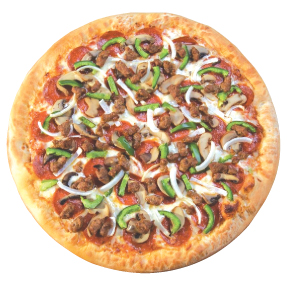

In [86]:
from IPython.display import Image
Image(filename='pizza.jpeg')

class MyLargePizza(object):
    def __init__(self, toppings=()):  
        self.toppings = toppings
        
    @property
    def pic(self):
        return Image(filename='pizza.jpeg')

pizza = MyLargePizza()
pizza.pic

You'll note that when we get the pizza picture, it's fetched using the `<instance>.<attribute>` syntax, the same thing you would see if we had set `self.pic = Image(filename='pizza.jpeg')` at class construction time. Under the hood, we're defining `self.pic` as a function, but because we used `@property`, it appears to us the same as an attribute.

Note: It's actually a Property object, which comes with a whole bunch of other fun attributes itself, but I'll leave that investigation as an exercise for the reader.

Other Things of Note
========
    - `functools.wraps` provides a decorator that will make the decorated function "look" like the 
    original.


In [ ]:
def my_decorator(unchanging_func):
    def inner(*args, **kwargs):
        return unchanging_func(*args, **kwargs)
    return inner

@my_decorator
def my_very_cool_function():
    print("You 'da best.")

In [ ]:
# What do we expect here?
my_very_cool_function.__name__

In [ ]:
from functools import wraps

def my_decorator(unchanging_func):
    @wraps(unchanging_func)
    def inner(*args, **kwargs):
        return unchanging_func(*args, **kwargs)

    return inner

@my_decorator
def my_very_cool_function():
    print("You 'da best.")

In [ ]:
my_very_cool_function.__name__

Helpful References
==================

Great Code Examples:
https://www.codeschool.com/blog/2016/05/12/a-guide-to-python-decorators/

Developer Tea:
https://spec.fm/podcasts/developer-tea/16125

Challenge:
https://github.com/quantopian/zipline/blob/51eda063238cd28b6b5cd61c3fb887d2a773e8ce/tests/data/bundles/test_quandl.py#L79-L87